In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

def safe_array_divide(numerator, denominator):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(numerator, denominator)
        ratio = np.nan_to_num(ratio, nan=0, posinf=0, neginf=0)
    return ratio


In [2]:
training_vars = ['jet_nTracks']
training_weight = ['equal_weight']
filename = './gbdt.model'

sample_all_jets_path = '../../../samples/sample_allpt_all_jets.pkl'

sample_path = '../../../samples/sample_allpt_all_jets.pkl'
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
layers = (10, 5, 4)


In [3]:
sample = pd.read_pickle(sample_all_jets_path)
sample = sample[sample['pt_idx']==0]

In [4]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [5]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [6]:
with open(filename, 'rb') as f:
    clf = pickle.load(f)

In [7]:
clf

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, random_state=42,
                           verbose=1)

In [8]:
features = [*sample.columns[:6]] + ['new_MLPprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(-4, 4.0, 51),
}


In [9]:
y_sample = clf.decision_function(sample[training_vars])
sample['new_GBDTscore'] = y_sample


In [10]:
sample.to_pickle('pred_sample.pkl')

In [11]:
sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_GBDTscore
7,525.046448,-1.230899,21.0,0.026432,0.188511,0.136256,1.0,1.0,0.502558,1.737371e-07,1.0,0,0.0,0.640106
11,519.972595,-1.157604,17.0,0.120245,0.257995,-0.025059,21.0,1.0,1.053274,3.573635e-07,1.0,0,1.0,-0.042793
15,533.982361,-1.150206,11.0,0.015249,0.185861,-0.274700,2.0,1.0,0.698572,2.415003e-07,1.0,0,0.0,-1.595621
17,534.412231,-0.183188,40.0,0.198334,0.333095,0.310029,21.0,1.0,0.394101,1.362431e-07,0.0,0,1.0,2.184582
18,503.886597,0.486479,40.0,0.086191,0.283057,0.412483,21.0,1.0,1.292122,4.384019e-07,1.0,0,1.0,2.184582


# test extraction

## no reweighting

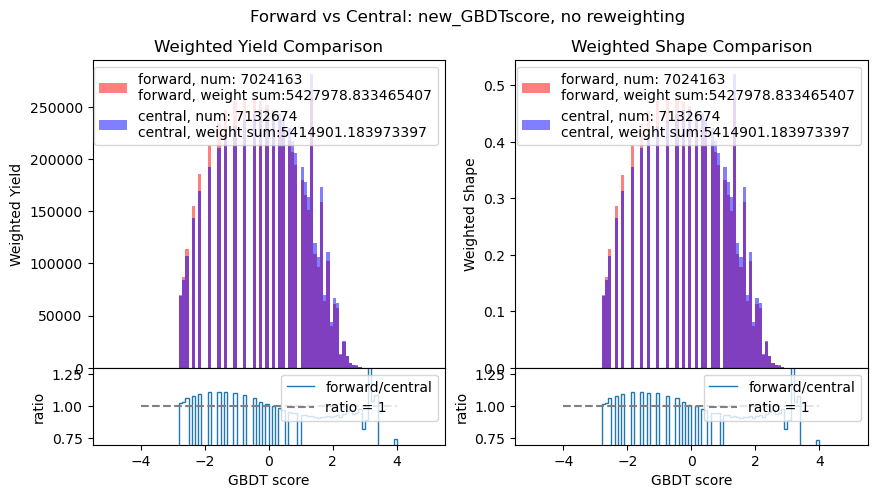

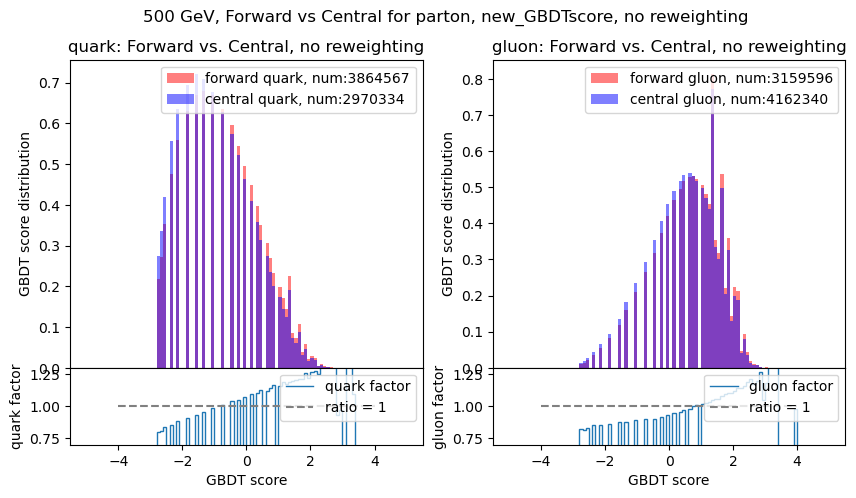

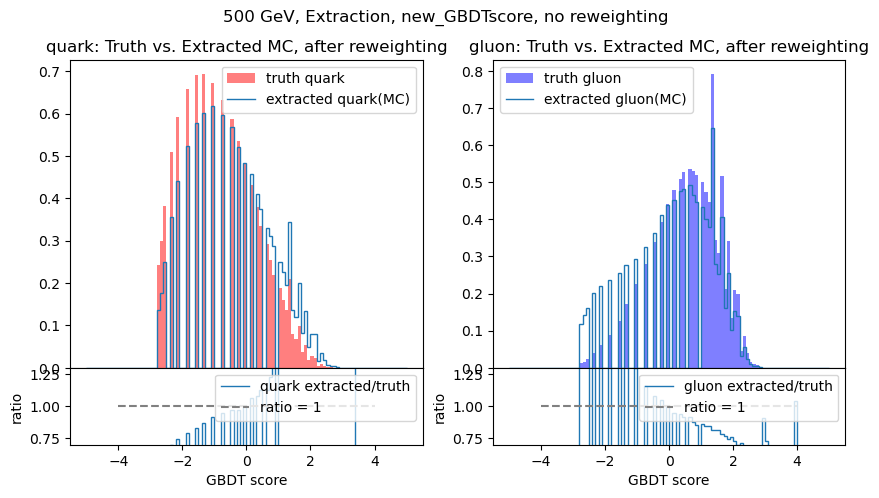

In [12]:
sample['quark_reweighting_weights'] = sample['event_weight'].copy()
sample['gluon_reweighting_weights'] = sample['event_weight'].copy()
newbdt_bins = np.linspace(-5, 5, 101)
feature = 'new_GBDTscore'
pt_idx = 5
reweighted_sample = []
# for pt_idx, pt in enumerate(label_pt_bin[:-1]):
# for pt_idx, pt in enumerate(label_pt_bin[pt_idx:pt_idx+1]):
for pt_idx, pt in enumerate(label_pt_bin[0:1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx]  
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    #### Forward vs Central 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward, _, _ = ax[0][0].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5)
    hist_central, _, _ = ax[0][0].hist(central[feature], bins = newbdt_bins, weights = central['event_weight'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['event_weight'])}", 
                                       color='blue', alpha = 0.5)
    ax[0][0].legend()
    ax[0][0].set_xlabel(feature)
    ax[0][0].set_ylabel(f"Weighted Yield")
    ax[0][0].set_title(f"Weighted Yield Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][0].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('GBDT score')


    hist_forward, _, _ = ax[0][1].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5, density=True)
    hist_central, _, _ = ax[0][1].hist(central[feature], bins = newbdt_bins, weights = central['event_weight'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['event_weight'])}", 
                                       color='blue', alpha = 0.5, density=True)    
    ax[0][1].legend()
    ax[0][1].set_xlabel(feature)
    ax[0][1].set_ylabel(f"Weighted Shape")
    ax[0][1].set_title(f"Weighted Shape Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][1].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('GBDT score')

    fig.suptitle(f"Forward vs Central: {feature}, no reweighting")

    #### Quark, Gluon, Forward vs Central     
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward_quark, _, _ = ax[0][0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    hist_central_quark, _, _ = ax[0][0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0][0].legend()
    ax[0][0].set_ylabel('GBDT score distribution')
    ax[0][0].set_title('quark: Forward vs. Central, no reweighting')

    newMLP_quark_factor = safe_array_divide(numerator=hist_forward_quark, denominator=hist_central_quark) 
    ax[1][0].stairs(values=newMLP_quark_factor, edges=newbdt_bins, label=f'quark factor')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('quark factor')
    ax[1][0].set_xlabel('GBDT score')



    new_clf_idx = pd.cut(_sample[feature], bins=newbdt_bins, right=False, labels=False) 
    for i, score in enumerate(newbdt_bins[:-1]):
        mod_idx = np.where(new_clf_idx == i)[0]
        _sample.iloc[mod_idx, _sample.columns.get_loc('quark_reweighting_weights')] *= newMLP_quark_factor[i]


    hist_forward_gluon, _, _ = ax[0][1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    hist_central_gluon, _, _ = ax[0][1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[0][1].set_title('gluon: Forward vs. Central, no reweighting')
    ax[0][1].legend()
    ax[0][1].set_ylabel('GBDT score distribution')
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}, no reweighting")

    newMLP_gluon_factor = safe_array_divide(numerator=hist_forward_gluon, denominator=hist_central_gluon) 
    ax[1][1].stairs(values=newMLP_gluon_factor, edges=newbdt_bins, label=f'gluon factor')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('gluon factor')
    ax[1][1].set_xlabel('GBDT score')


    reweighted_sample.append(_sample)
    
    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)

    # Do a simple extraction test
    # MC closure 
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)

#     n_forward_quark2 = np.sum(forward_quark['event_weight'])
#     n_central_quark2 = np.sum(central_quark['event_weight'])
#     n_forward2 = np.sum(forward['event_weight'])
#     n_central2 = np.sum(central['event_weight'])

#     frac_forward_quark2 = n_forward_quark2 / n_forward2
#     frac_central_quark2 = n_central_quark2 / n_central2

#     frac_forward_gluon2 = 1 - frac_forward_quark2
#     frac_central_gluon2 = 1 - frac_central_quark2

#     f2 = np.array([[frac_forward_quark2,  frac_forward_gluon2], [frac_central_quark2, frac_central_gluon2]])
#     f2_inv = np.linalg.inv(f2)


#     extract_p_Quark = f2_inv[0][0] * hist_forward + f2_inv[0][1]* hist_central 
#     extract_p_Gluon = f2_inv[1][0] * hist_forward + f2_inv[1][1]* hist_central 

    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)

    extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
    extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 
    #### Extraction plots 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_truth_quark, _, _ = ax[0][0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0][0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0][0].legend()
    ax[0][0].set_title('quark: Truth vs. Extracted MC, no reweighting')

    extraction_quark_ratio = safe_array_divide(numerator=extract_p_Quark, denominator=hist_truth_quark) 
    ax[1][0].stairs(values=extraction_quark_ratio, edges=newbdt_bins, label=f'quark extracted/truth')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('GBDT score')

    hist_truth_gluon, _, _ = ax[0][1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
                                label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[0][1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[0][1].legend()
    ax[0][1].set_title('gluon: Truth vs. Extracted MC, no reweighting')

    extraction_gluon_ratio = safe_array_divide(numerator=extract_p_Gluon, denominator=hist_truth_gluon) 
    ax[1][1].stairs(values=extraction_gluon_ratio, edges=newbdt_bins, label=f'gluon extracted/truth')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('GBDT score')

    fig.suptitle(f"{pt} GeV, Extraction, {feature}, no reweighting")

reweighted_sample = pd.concat(reweighted_sample)

In [13]:
reweighted_sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_GBDTscore,quark_reweighting_weights,gluon_reweighting_weights
7,525.046448,-1.230899,21.0,0.026432,0.188511,0.136256,1.0,1.0,0.502558,1.737371e-07,1.0,0,0.0,0.640106,0.561656,0.502558
11,519.972595,-1.157604,17.0,0.120245,0.257995,-0.025059,21.0,1.0,1.053274,3.573635e-07,1.0,0,1.0,-0.042793,1.126536,1.053274
15,533.982361,-1.150206,11.0,0.015249,0.185861,-0.274700,2.0,1.0,0.698572,2.415003e-07,1.0,0,0.0,-1.595621,0.650210,0.698572
17,534.412231,-0.183188,40.0,0.198334,0.333095,0.310029,21.0,1.0,0.394101,1.362431e-07,0.0,0,1.0,2.184582,0.501580,0.394101
18,503.886597,0.486479,40.0,0.086191,0.283057,0.412483,21.0,1.0,1.292122,4.384019e-07,1.0,0,1.0,2.184582,1.644508,1.292122


## after reweighting

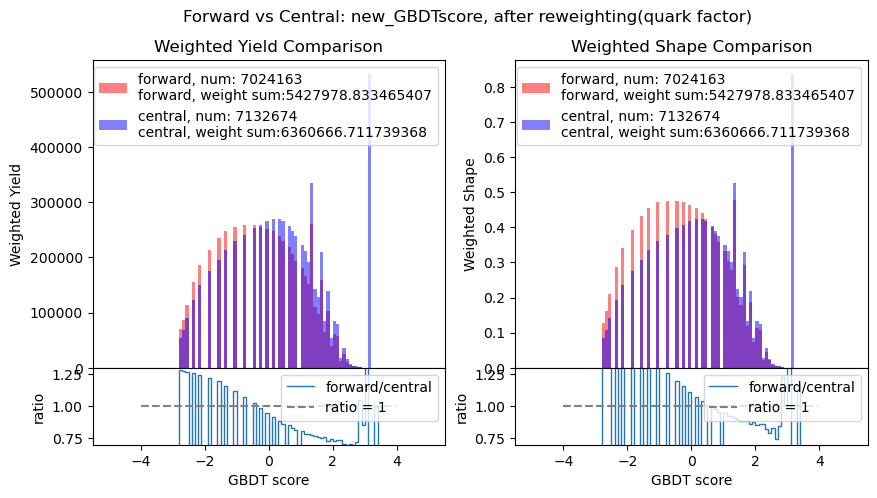

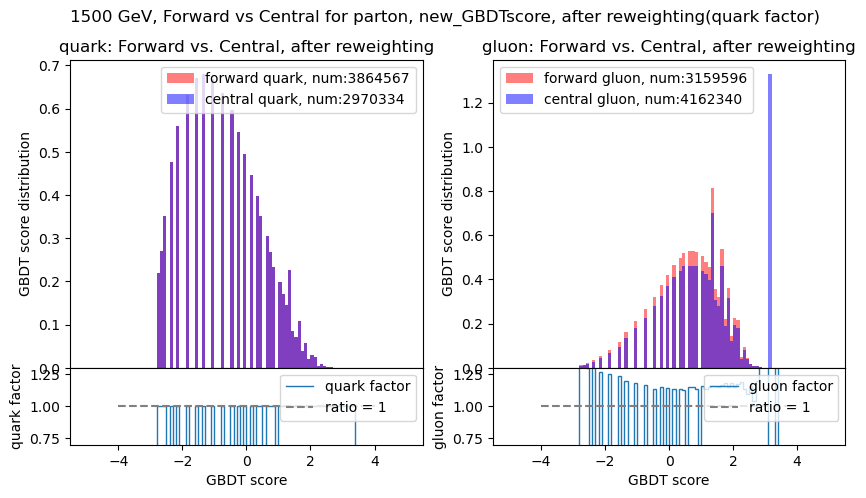

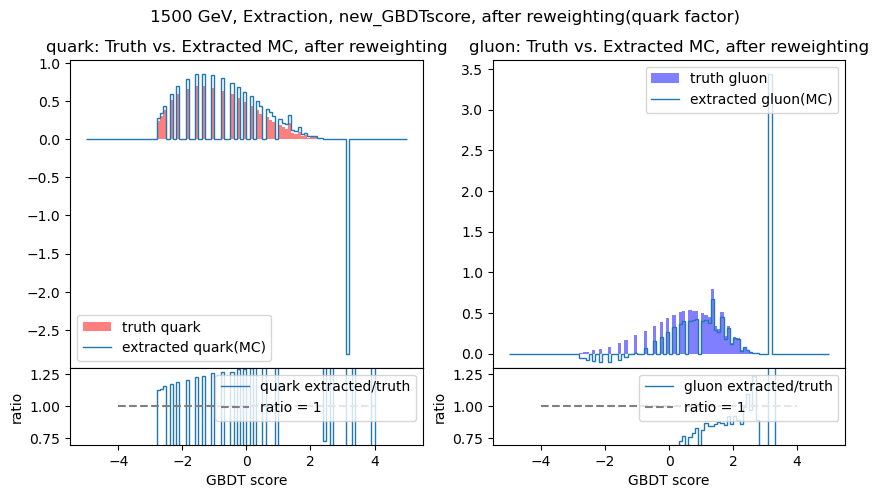

In [14]:
# for pt_idx, pt in enumerate(label_pt_bin[:-1]):
# for pt_idx, pt in enumerate(label_pt_bin[pt_idx:pt_idx+1]):
for pt_idx, pt in enumerate(label_pt_bin[-2:-1]):
    sample_pt = reweighted_sample[reweighted_sample['pt_idx'] == pt_idx]  
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    #### Forward vs Central 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward, _, _ = ax[0][0].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5)
    hist_central, _, _ = ax[0][0].hist(central[feature], bins = newbdt_bins, weights = central['quark_reweighting_weights'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['quark_reweighting_weights'])}", 
                                       color='blue', alpha = 0.5)
    ax[0][0].legend()
    ax[0][0].set_xlabel(feature)
    ax[0][0].set_ylabel(f"Weighted Yield")
    ax[0][0].set_title(f"Weighted Yield Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][0].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('GBDT score')


    hist_forward, _, _ = ax[0][1].hist(forward[feature], bins = newbdt_bins, weights = forward['event_weight'], 
                                       label = f"forward, num: {len(forward)}\nforward, weight sum:{np.sum(forward['event_weight'])}", 
                                       color='red', alpha = 0.5, density=True)
    hist_central, _, _ = ax[0][1].hist(central[feature], bins = newbdt_bins, weights = central['quark_reweighting_weights'], 
                                       label = f"central, num: {len(central)}\ncentral, weight sum:{np.sum(central['quark_reweighting_weights'])}", 
                                       color='blue', alpha = 0.5, density=True)    
    ax[0][1].legend()
    ax[0][1].set_xlabel(feature)
    ax[0][1].set_ylabel(f"Weighted Shape")
    ax[0][1].set_title(f"Weighted Shape Comparison")

    ratio_forwad_vs_central = safe_array_divide(numerator=hist_forward, denominator=hist_central)
    ax[1][1].stairs(values=ratio_forwad_vs_central, edges=newbdt_bins, label=f'forward/central')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('GBDT score')

    fig.suptitle(f"Forward vs Central: {feature}, after reweighting(quark factor)")


    #### Quark, Gluon, Forward vs Central     
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_forward_quark, _, _ = ax[0][0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    hist_central_quark, _, _ = ax[0][0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['quark_reweighting_weights'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0][0].legend()
    ax[0][0].set_ylabel('GBDT score distribution')
    ax[0][0].set_title('quark: Forward vs. Central, after reweighting')


    newMLP_quark_factor = safe_array_divide(numerator=hist_forward_quark, denominator=hist_central_quark) 
    ax[1][0].stairs(values=newMLP_quark_factor, edges=newbdt_bins, label=f'quark factor')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('quark factor')
    ax[1][0].set_xlabel('GBDT score')


    hist_forward_gluon, _, _ = ax[0][1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    hist_central_gluon, _, _ = ax[0][1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['quark_reweighting_weights'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[0][1].set_title('gluon: Forward vs. Central, after reweighting')
    ax[0][1].legend()
    ax[0][1].set_ylabel('GBDT score distribution')
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}, after reweighting(quark factor)")

    newMLP_gluon_factor = safe_array_divide(numerator=hist_forward_gluon, denominator=hist_central_gluon) 
    ax[1][1].stairs(values=newMLP_gluon_factor, edges=newbdt_bins, label=f'gluon factor')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('gluon factor')
    ax[1][1].set_xlabel('GBDT score')

    #### Apply quark factor 
    new_clf_idx = pd.cut(_sample[feature], bins=newbdt_bins, right=False, labels=False) 
    for i, score in enumerate(newbdt_bins[:-1]):
        mod_idx = np.where(new_clf_idx == i)[0]
        _sample.iloc[mod_idx, _sample.columns.get_loc('quark_reweighting_weights')] *= newMLP_quark_factor[i]

    # Do a simple extraction test
    # MC closure 
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['quark_reweighting_weights'], density = True)

#     n_forward_quark2 = np.sum(forward_quark['event_weight'])
#     n_central_quark2 = np.sum(central_quark['quark_reweighting_weights'])
#     n_forward2 = np.sum(forward['event_weight'])
#     n_central2 = np.sum(central['quark_reweighting_weights'])

#     frac_forward_quark2 = n_forward_quark2 / n_forward2
#     frac_central_quark2 = n_central_quark2 / n_central2

#     frac_forward_gluon2 = 1 - frac_forward_quark2
#     frac_central_gluon2 = 1 - frac_central_quark2

#     f2 = np.array([[frac_forward_quark2,  frac_forward_gluon2], [frac_central_quark2, frac_central_gluon2]])
#     f2_inv = np.linalg.inv(f2)

#     extract_p_Quark = f2_inv[0][0] * hist_forward + f2_inv[0][1]* hist_central 
#     extract_p_Gluon = f2_inv[1][0] * hist_forward + f2_inv[1][1]* hist_central 

    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)

    extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
    extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

    #### Extraction plots 
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    hist_truth_quark, _, _ = ax[0][0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0][0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0][0].legend()
    ax[0][0].set_title('quark: Truth vs. Extracted MC, after reweighting')

    extraction_quark_ratio = safe_array_divide(numerator=extract_p_Quark, denominator=hist_truth_quark) 
    ax[1][0].stairs(values=extraction_quark_ratio, edges=newbdt_bins, label=f'quark extracted/truth')
    ax[1][0].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][0].legend()
    ax[1][0].set_ylim(0.7, 1.3)
    ax[1][0].set_ylabel('ratio')
    ax[1][0].set_xlabel('GBDT score')

    hist_truth_gluon, _, _ = ax[0][1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
                                label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[0][1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[0][1].legend()
    ax[0][1].set_title('gluon: Truth vs. Extracted MC, after reweighting')

    extraction_gluon_ratio = safe_array_divide(numerator=extract_p_Gluon, denominator=hist_truth_gluon) 
    ax[1][1].stairs(values=extraction_gluon_ratio, edges=newbdt_bins, label=f'gluon extracted/truth')
    ax[1][1].hlines(y = 1, xmin = -4, xmax = 4, color = 'gray', linestyle = '--', label='ratio = 1')
    ax[1][1].legend()
    ax[1][1].set_ylim(0.7, 1.3)
    ax[1][1].set_ylabel('ratio')
    ax[1][1].set_xlabel('GBDT score')


    fig.suptitle(f"{pt} GeV, Extraction, {feature}, after reweighting(quark factor)")